In [98]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
from drn_interactions.transforms.spikes import SpikesHandler
from sklearn.preprocessing import minmax_scale, robust_scale
from sklearn.feature_extraction.text import TfidfTransformer

In [52]:
def reorder_df_affinity(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, idx]

def reorder_spikes(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, :]


def get_affinity(session_name, t_start=0, t_stop=1800, rectify=True):
    loader = SpontaneousActivityLoader(session_name=session_name, t_start=t_start, t_stop=t_stop)
    preprocessor = InteractionsPreprocessor(z=True)
    mod = PairwiseCorr(rectify=rectify)

    spikes = preprocessor(loader())
    return mod.fit(spikes).get_adjacency_df()

In [17]:
neuron_types = load_derived_generic("neuron_types.csv")
sessions = neuron_types["session_name"].unique()
print(sessions.tolist())

['ESHOCK_03_LOC1', 'ESHOCK_04_LOC1', 'ESHOCK_06_LOC1', 'ESHOCK_07_LOC1', 'ESHOCK_08_LOC1', 'ESHOCK_09_LOC1', 'hamilton_10', 'hamilton_03', 'hamilton_04', 'hamilton_09', 'hamilton_31', 'hamilton_38', nan, 'hamilton_37', 'hamilton_35', 'hamilton_36', 'hamilton_32', 'acute_15', 'acute_16', 'acute_01', 'acute_14', 'acute_12', 'acute_11']


<AxesSubplot:xlabel='neuron_id', ylabel='neuron_id'>

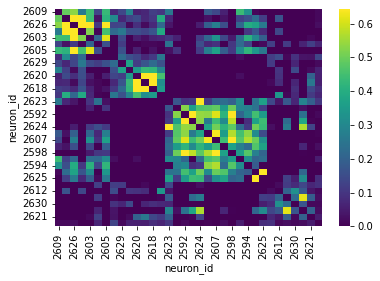

In [109]:
session_name = "acute_11"
# session_name = sessions[13]
ensembles = (
    load_derived_generic("ensembles/spont - ensembles - true.csv")
    .query("session_name == @session_name")
    .sort_values("neuron_id")
)
labels = ensembles["ensemble_id"].values


spikes = SpikesHandler(
    block="pre",
    bin_width=1,
    t_stop=1800,
    session_names=[session_name],
).binned_piv

# .apply(minmax_scale).T

vals = TfidfTransformer().fit_transform(spikes).todense()
spikes = pd.DataFrame(vals, columns=spikes.columns, index=spikes.index).apply(minmax_scale)

spikes = reorder_spikes(spikes, labels)

df_affinity = get_affinity(session_name)
df_affinity = reorder_df_affinity(df_affinity, labels)

<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

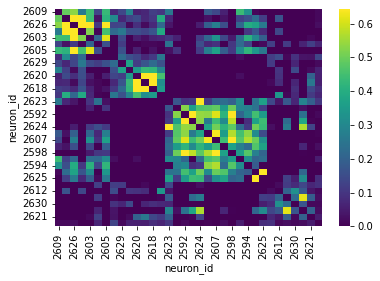

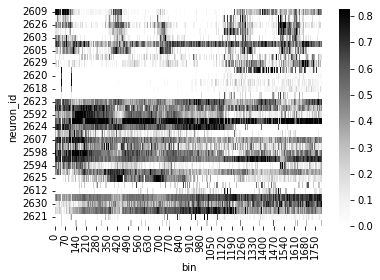

In [113]:

sns.heatmap(df_affinity, cmap="viridis", vmin=0, robust=True)
plt.figure()
sns.heatmap(spikes, cmap="Greys", vmin=0, robust=True)

### Example Rsc

### Example Ensemble

- Line plot of smoothed firing rate

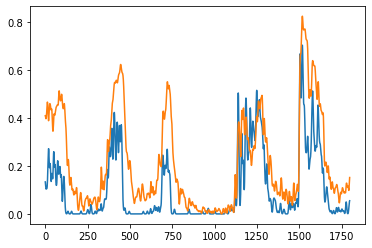

In [127]:
from scipy.ndimage import gaussian_filter1d
spikes_p = spikes.transform(gaussian_filter1d, sigma=3, axis=1)
n1 = spikes_p.iloc[0, :]
n2 = spikes_p.iloc[1, :]
n3 = spikes_p.iloc[2, :]
time = spikes_p.columns

# plt.plot(time, n1, label="n1")
plt.plot(time, n2, label="n2")
plt.plot(time, n3, label="n3")

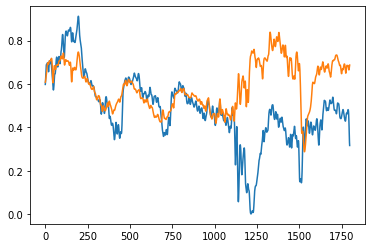

In [135]:
n1 = spikes_p.iloc[23, :]
n2 = spikes_p.iloc[22, :]
time = spikes_p.columns

# plt.plot(time, n1, label="n1")
plt.plot(time, n2, label="n2")
plt.plot(time, n1, label="n3")

### Example Ensemble Stability

- Correlation matrix and heatmap

### Interactions By Bin Width

- Point plot v shuffle
- Facet grid by rows
- Rsc, number of ensembles, sequenciness

### Interactions Prediction

- Proportion of neurons in hued by whether they are in an ensemble
- Edge weight predicted by neuron type combination and distance
- Ensemble membership by distance and neuron type combination

### Stability Props

- Node ensemble MI
- Edge correlation